
# **Image Colorization With GANs**

GANs are the state-of-the-art machine learning models which can generate new data instances from existing ones. They use a very interesting technique, inspired from the Game Theory, to generate realistic samples. 

In this notebook, we'll use GANs to colorize a grayscale ( B/W ) image. In addition to that, our generator model will have a structure similar to that of a UNet i.e the one with skip connections.



We'll now parse the images ( RGB images to be precise ) one by one, and transform each one to a grayscale image using PIL's `.convert( 'L' )` method. So our dataset will have samples of $( \ grayscale \ image \ , \ RGB \ image \ )$

If you are running this in Colab, you can set the number of images that the model uses with the `dataset_size` variable so that the execution speed isn't throttled by a large number of images.


In [1]:
import sys


IN_COLAB = 'google.colab' in sys.modules

# Running with Google Colab:

Step 1: Download the dataset from [https://zenodo.org/record/4307612#.Ym2CrtrMKUk](https://zenodo.org/record/4307612#.Ym2CrtrMKUk) and extract it to a folder named '10 reps'. The whole dataset contains about 4300 high resolution butterfly images and is around 20GB. The whole dataset isn't necessary for this project, and we only trained our model on the first 617 images from it.

Step 2: Generate a dataset of butterfly images on blank white backgrounds. You can do this by running `python butterfly_dataset.py`. There are some known complications when creating the dataset, so see the documentation in `ButterflyDataset.create_dataset()` for more information.

Step 3: Once you have created the dataset, upload the `butterflies` folder to your Google Drive and run the below cells:

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    master_dir = 'processed'

    %cd /content/drive/MyDrive/butterflies/

Ensure that TPU hardware acceleration is activate in your Colab settings then run the below cell:

In [3]:
if IN_COLAB:
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)

    try:
      tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
      print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
      raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Running on your Local Machine:

Step 1: Download the dataset from [https://zenodo.org/record/4307612#.Ym2CrtrMKUk](https://zenodo.org/record/4307612#.Ym2CrtrMKUk) and extract it to a folder named '10 reps'. The whole dataset contains about 4300 high resolution butterfly images and is around 20GB. The whole dataset isn't necessary for this project, and we only trained our model on the first 617 images from it.

Step 2: Generate a dataset of butterfly images on blank white backgrounds. You can do this by running `python butterfly_dataset.py`. There are some known complications when creating the dataset, so see the documentation in `ButterflyDataset.create_dataset()` for more information.

In [4]:
if not IN_COLAB:
    master_dir = 'butterflies/processed'

# Below are the cells needed to setup the GAN and dataset:

In [5]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras


# The batch size we'll use for training. If the batch size is too large, you may encounter an OOM error
batch_size = 16

# Size of the image required to train our model
img_size = 224

x = []
y = []

if IN_COLAB:
    dataset_size = 128
else:
    dataset_size = 128 # use the whole dataset

for image_file in os.listdir(master_dir)[:dataset_size]:
    rgb_image = Image.open( os.path.join( master_dir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( img_size , img_size , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )
    
# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1, shuffle=False)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( batch_size )


2022-05-05 00:42:57.497936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 00:42:57.508022: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 00:42:57.508753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-05 00:42:57.510603: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags


## **2. The GAN**

In this section, we'll create our GAN model step-by-step with Keras. First, we'll implement the generator then the discriminator and finally the loss functions required by both of them.



### **A. Generator** 

Our generator ( represented as $G$ ) will take in grayscale image $x$ and produce a RGB image $G( x )$. Note, $x$ will be a tensor of shape $( \ batch \ size \ , \ 224 \ , \ 224 \ , \ 1 \ )$ and the output $G(x)$ will have a shape $( \ batch \ size \ , \ 224 \ , \ 224 \ , \ 3 \ )$

* Our generator will have a encoder-decoder structure, similar to the UNet architecture. Additionally, we use Dilated convolutions to have a larger receptive field.

* We introduce skip connections in our model so as to have better flow of information from the encoder to the decoder.


In [6]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model



### **B. Discriminator**

The discriminator model, represented as $D$, will take in the *real image* $y$ ( from the training data ) and the *generated image* $G(x)$ ( from the generator ) to output two probabilities.

* We train the discriminator in such a manner that is able to differentiate the *real images* and the generated *images*. So, we train the model such that $y$ produces a output of $1.0$ and $G(x)$ produces an output of $0.0$.
* Note that instead of using hard labels like $1.0$ and $0.0$, we use soft labels which are close to 1 and 0. So for a hard label of $1.0$, the soft label will be $(1 - \epsilon)$ where $\epsilon$ is picked uniformly from $( 0 , 0.1 ]$


In [7]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 224 , 224 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' ) 
    ]
    model = tf.keras.models.Sequential( layers )
    return model



### **C. Loss Functions**

We'll now implement the loss functions for our GAN model. As you might know that we have two loss functions, one for the generator and another for the discriminator. 

* For our generator, we'll use the L2/MSE loss function.
* For optimization, we use the Adam optimizer with a learning rate of 0.0005



In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()



## **3. Training The GAN**

So finally, we'll train our GAN on the dataset, we prepared earlier.


In [9]:
@tf.function
def train_step( input_x , real_y ):
   
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)
        
        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )
    
    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




Run the cell below, to start the training

In [10]:
num_epochs = 100

for e in range( num_epochs ):
    print(f'\rEpoch {e}/{num_epochs}', end='', flush=True)
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        #print( x.shape )
        train_step( x , y )
        


Epoch 0/100

2022-05-05 00:43:01.318586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


Epoch 99/100


## **4. Results**

We plotted the input, output and the original images respectively, from a part of the dataset to find out the results.


In [11]:
num_display_imgs = 12
y = generator( test_x[0 : num_display_imgs] ).numpy()

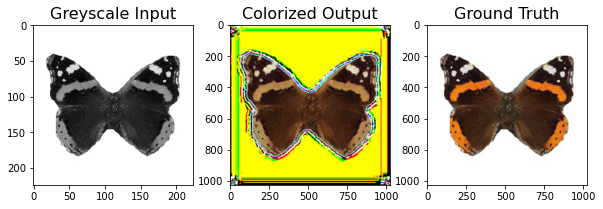

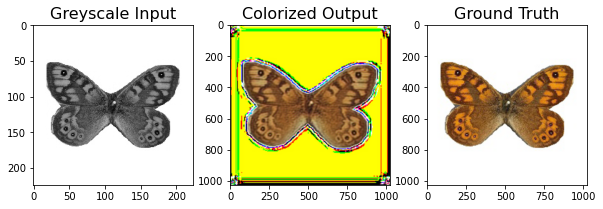

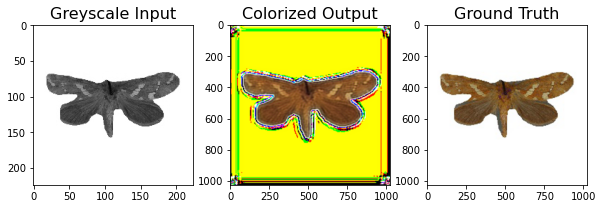

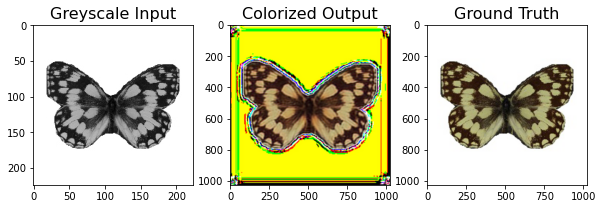

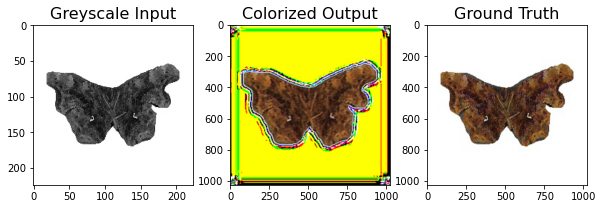

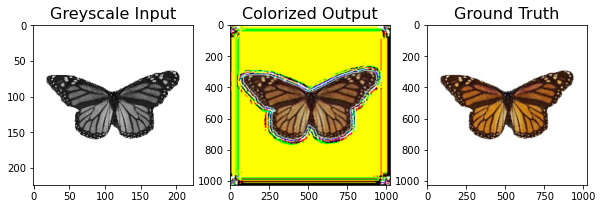

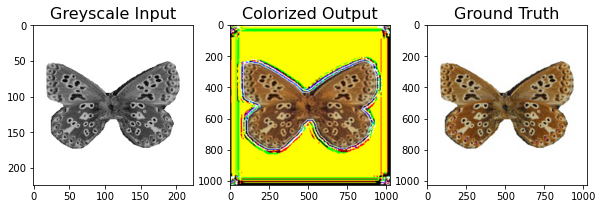

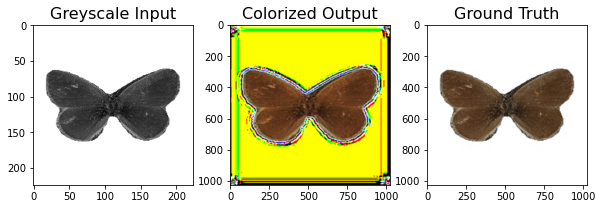

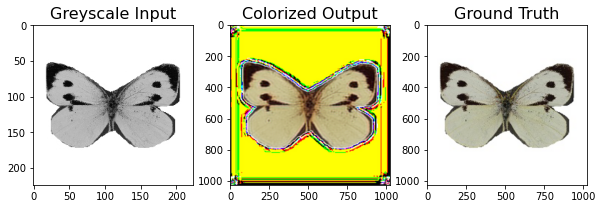

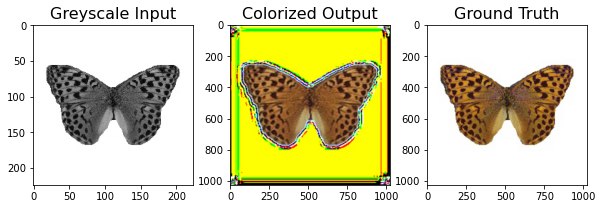

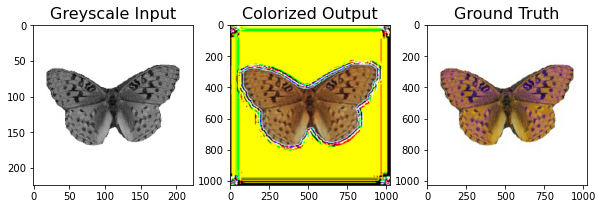

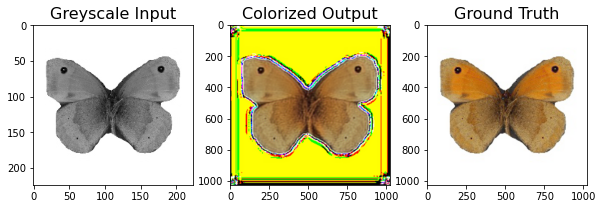

In [12]:
for i in range(num_display_imgs):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Greyscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((224,224)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )


  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

Therefore, the overwhelming reslts depicts the power of GANs and the disruption which can be broght through them.

# Re-running on the training set (just to see how it looks)

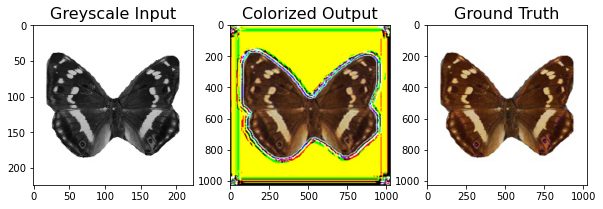

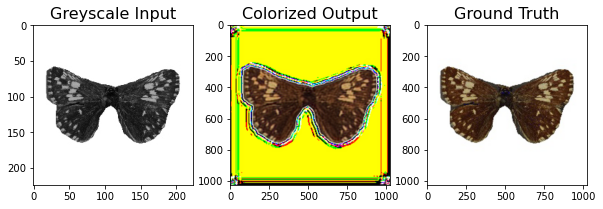

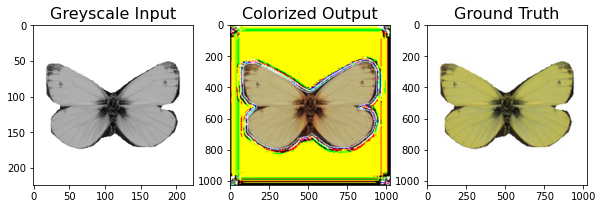

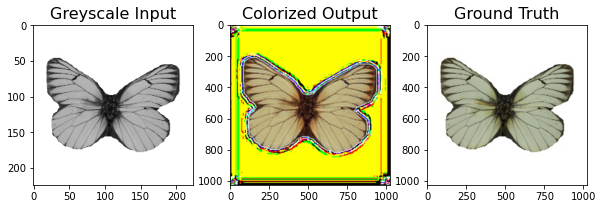

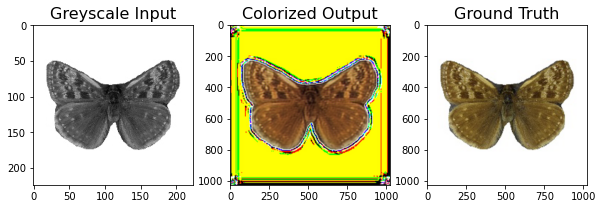

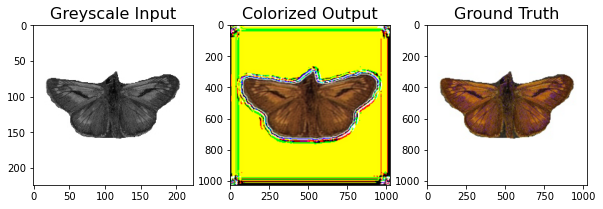

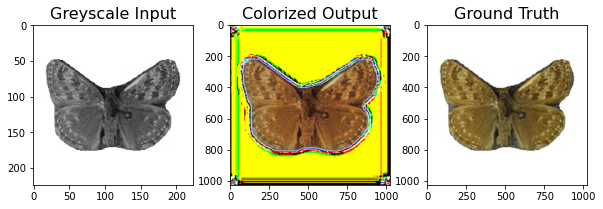

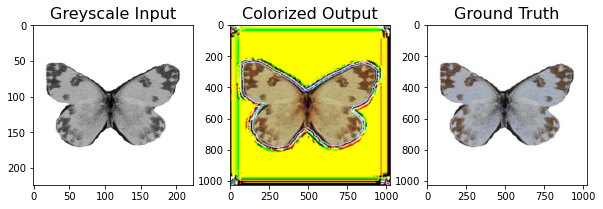

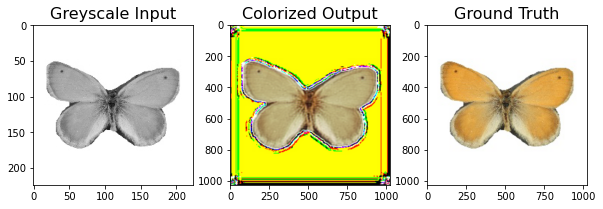

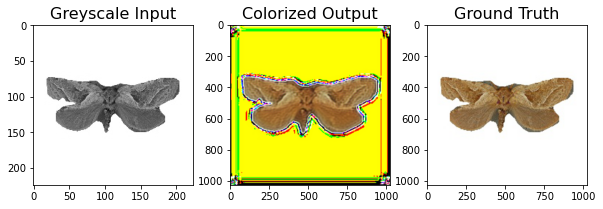

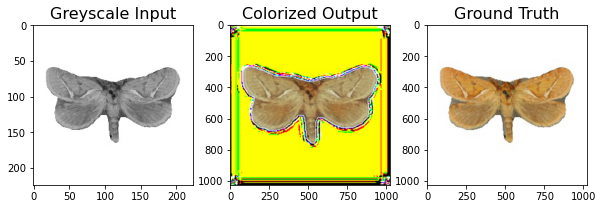

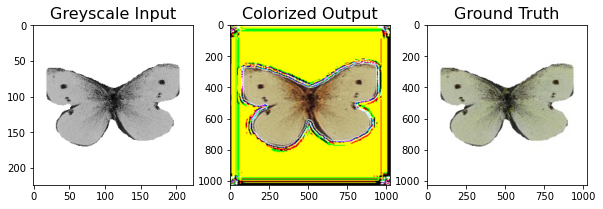

In [13]:

y = generator( train_x[0 : num_display_imgs] ).numpy()
for i in range(num_display_imgs):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Greyscale Input', fontsize=16)
  plt.imshow( train_x[i].reshape((224,224)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)    
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )


  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( train_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()